### Image Classification on the MNIST Dataset

In this chapter, I learn image classification Machine Learning algorithms, and how they work. Before anything, prepare the workspace.

In [20]:
import os
import shutil
from sklearn.datasets import fetch_openml

MB = 1024 * 1024
DATA_HOME = "../datasets"
NEW_DATASET_EVERYTIME = False

print("New dataset everytime:", NEW_DATASET_EVERYTIME)

if NEW_DATASET_EVERYTIME and os.path.exists(DATA_HOME):
    shutil.rmtree(DATA_HOME)
    print("Dataset directory removed")

    os.makedirs(DATA_HOME)
    print("Now downloading dataset")

if not NEW_DATASET_EVERYTIME:
    print("Reusing existing dataset")

MNIST = fetch_openml("mnist_784", as_frame=False, data_home=DATA_HOME)

data_size = MNIST.data.nbytes / MB
target_size = MNIST.target.nbytes / MB
total = data_size + target_size

print(f"\n{'Dataset size:':12} {data_size:4.2f} MB")
print(f"{'Target size:':12} {target_size:4.2f} MB")
print(f"{'Total size:':12} {total:4.2f} MB\n")

print("Done")

New dataset everytime: False
Reusing existing dataset

Dataset size: 418.70 MB
Target size: 0.53 MB
Total size:  419.24 MB

Done


### Exploration Phase

I'm looking at potentially useful information about the features (X) and labels (y), in general what's known as 'exploratory data analysis'.

In [43]:
features, labels = MNIST.data, MNIST.target

print("Features (X):", features)
print("Labels (y):", labels)

print("\nShape (X):", features.shape)
print("Shape (y):", labels.shape)

print("\nFeatures data (row 1):\n", features[0, : ])
print("\nRow 1 size:", features[0].size)

Features (X): [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Labels (y): ['5' '0' '4' ... '4' '5' '6']

Shape (X): (70000, 784)
Shape (y): (70000,)

Features data (row 1):
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   3  18  18  18 126 136 175  26 166 255
 247 127   0   0   0   0   0   0   0   0   0   0   0   0  30  36  94 154
 170 253 253 253 253 253

The dataset has 70,000 images each with 784 features.

#### Plotting images

Since the images are supposed to be 28x28 pixels, and the 784 pixels represent the color intensity of the images at each pixel, we can
print the digits using Matplotlib. All we need to do is reshape the data into a 28x28 matrix and color the points appropriately.

Label at this index: 4


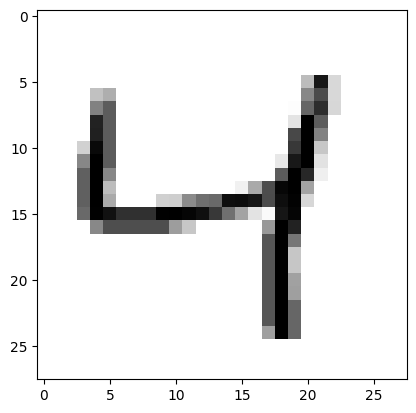

In [46]:
from matplotlib import pyplot as plt
import numpy as np

def plot_image(image_data):
    image = np.reshape(image_data, (28, 28))
    plt.imshow(image, cmap="binary")
    # plt.axis("off")

index = 2
first_image_data = features[index]
print("Label at this index:", labels[index])
plot_image(first_image_data)

### Split Test and Train Datasets

I will use the first 60,000 images for training and the remaining 10,000 for testing and evaluating the model's final performance.

In [ ]:
SPLIT = 60_000

features_train, features_test = features[:SPLIT], features[SPLIT:]
labels_train, labels_test = labels[:SPLIT], labels[SPLIT:]

print("Features (train) size:", features_train.shape[0])
print("Features (test) size:", features_test.shape[0])

print("\nLabels (train) size:", labels_train.shape[0])
print("Labels (test) size:", labels_test.shape[0])

Features (train) size: 60000
Features (test) size: 10000

Labels (train) size: 60000
Labels (test) size: 10000


### Training a Binary Classifier

First of all we'll work on a binary classifier for the number 5. We'll split the labels (both at the test and train).


In [62]:
labels_train_5 = (labels_train == '5')
labels_test_5 = (labels_test == '5')

labels_train_5

array([ True, False, False, ...,  True, False, False], shape=(60000,))

In the book, they use a Stochastic Gradient Descent (SGD) classifier.

In [67]:
from sklearn.linear_model import SGDClassifier

RANDOM_STATE = 42

SGD_clf = SGDClassifier(random_state=RANDOM_STATE)
SGD_clf.fit(features_train, labels_train_5)

,loss,'hinge'
,penalty,'l2'
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,1000
,tol,0.001
,shuffle,True
,verbose,0
,epsilon,0.1
,n_jobs,None


In [71]:
# Training is complete, note, first_image_data points to 4 presently
# the model should accurately predict false
SGD_clf.predict([features_train[0], first_image_data])

array([ True, False])

### Evaluating Our Model's Performance

First off, our trusty K-Fold Cross Validation.

In [77]:
from sklearn.model_selection import cross_val_score

# Model evaluation configuration parameters
K_FOLDS = 3
SCORING_CRITERIA = "accuracy"

cross_val_score(SGD_clf, features_train, labels_train_5, cv=K_FOLDS, scoring=SCORING_CRITERIA)

array([0.95035, 0.96035, 0.9604 ])

Impressive scores from the above across 3 folds. But alas, we've been deceived. It only ranks so high because the model has learned to guess "Not 5", since 5's make up only 10% of the dataset.

A much better way to measure the performance of a Classifier is to use what's called a Confusion Matrix.

In [79]:
from sklearn.model_selection import cross_val_predict

labels_train_5_pred = cross_val_predict(SGD_clf, features_train, labels_train_5, cv=K_FOLDS)
print("Labels predicted for number 5 (cross prediction):", labels_train_5_pred)

Labels predicted for number 5 (cross prediction): [ True False False ...  True False False]


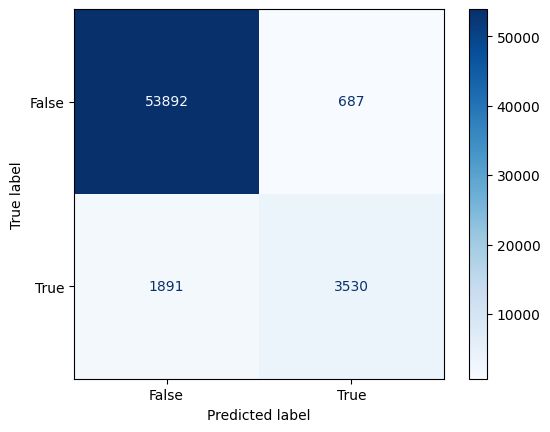

In [93]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

CMAP = "Blues"

cm = confusion_matrix(labels_train_5, labels_train_5_pred, labels=SGD_clf.classes_)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=SGD_clf.classes_)
cm_disp.plot(cmap=CMAP)

plt.show()